# EfficientNet Modeling

## Mount Google Drive

In [46]:
# Mount GDrive
# from google.colab import drive
# drive.mount('/content/drive')

In [47]:
# Put Colab in the context of this challenge
# import os

# os.chdir allows you to change directories, like cd in the Terminal
# os.chdir('/content/drive/MyDrive/raw_data_224')

In [48]:
!ls

eda_modelling_structure.ipynb Fer_EfficientNet.ipynb


## GPU Check

In [49]:
# Verifica tu GPU (si tienes):
import tensorflow as tf
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: []


## Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import seaborn as sns
import os
from collections import Counter

## Configs

Configuraciones escenciales para el modelo

In [42]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE

# Ajustar learning rate según tamaño del dataset
# Datasets pequeños necesitan LR más alto para aprender rápido
LEARNING_RATE = 0.001  # Aumentado de 0.001

# Ruta a tu dataset
DATA_PATH = '../data/raw_data_224'

# Carpeta para guardar modelos
MODELS_PATH = '../data/models'

# Crear carpeta de modelos si no existe
import os
if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)
    print(f"📁 Carpeta creada: {MODELS_PATH}")

# Mapeo de clases (IMPORTANTE: incluye red_spider_mite)
CLASS_NAMES = ['healthy', 'cerscospora', 'leaf_rust', 'miner', 'phoma']
NUM_CLASSES = len(CLASS_NAMES)

Control de volumen de datos

Controla cuántas imágenes usar para experimentación rápida.
Opciones:
  - None o 'full': Usa todo el dataset (~60K imágenes)
  - 100: Usa 100 imágenes totales (útil para debugging rápido)
  - 1000: Usa 1000 imágenes totales (prueba rápida)
  - 5000: Usa 5000 imágenes totales
  - 'half': Usa la mitad del dataset
  - 0.25: Usa el 25% del dataset (también acepta cualquier fracción 0.0-1.0)

In [ ]:
SAMPLE_SIZE = 0.25  # Cambia esto para experimentar

# Determinar nombre descriptivo para archivos
if SAMPLE_SIZE is None or SAMPLE_SIZE == 'full':
    sample_name = 'full'
elif SAMPLE_SIZE == 'half':
    sample_name = 'half'
elif isinstance(SAMPLE_SIZE, float):
    sample_name = f'{int(SAMPLE_SIZE*100)}pct'
else:
    sample_name = f'{SAMPLE_SIZE}'

print(f"📊 Tamaño de muestra: {sample_name}")

# Configuración adaptativa de epochs según tamaño de muestra
if SAMPLE_SIZE == 100:
    EPOCHS = 30  # Más epochs para muestras pequeñas
elif SAMPLE_SIZE == 1000:
    EPOCHS = 40
elif isinstance(SAMPLE_SIZE, float) and SAMPLE_SIZE <= 0.5:
    EPOCHS = 50
else:
    EPOCHS = 60  # Más epochs para dataset completo

# Detectar automáticamente las clases de enfermedad (todas excepto 'healthy')
disease_classes = [name for name in CLASS_NAMES if name != 'healthy']
num_disease_classes = len(disease_classes)

# Función para detectar desequilibrio extremo (definir aquí, usar después)
def find_rarest_disease_class(data_path, class_names, extreme_threshold=0.5):
    """
    Encuentra la clase de enfermedad con menos muestras solo si hay un desequilibrio extremo

    Args:
        data_path: Ruta al dataset
        class_names: Lista de nombres de clases
        extreme_threshold: Factor mínimo de diferencia para considerar "extremadamente rara"
                          (ej: 0.5 = la clase rara debe tener menos de la mitad que el promedio)

    Returns:
        tuple: (clase_más_rara, count, es_extrema, estadísticas)
    """
    class_counts = {}

    for class_name in class_names:
        if class_name == 'healthy':
            continue

        class_path = os.path.join(data_path, class_name)
        if os.path.exists(class_path):
            count = len([f for f in os.listdir(class_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = count

    if not class_counts:
        return None, 0, False, {}

    # Calcular estadísticas
    counts = list(class_counts.values())
    min_count = min(counts)
    max_count = max(counts)
    avg_count = sum(counts) / len(counts)

    # Encontrar la clase más rara
    rarest_class = min(class_counts, key=class_counts.get)

    # Determinar si es extremadamente rara
    # Criterios múltiples para considerar "extrema":
    ratio_vs_avg = min_count / avg_count if avg_count > 0 else 1
    ratio_vs_max = min_count / max_count if max_count > 0 else 1

    # Es extrema si tiene menos del threshold% comparado con el promedio
    # Y menos del 30% comparado con la clase más común
    is_extreme = (ratio_vs_avg < extreme_threshold and ratio_vs_max < 0.3)

    stats = {
        'all_counts': class_counts,
        'min_count': min_count,
        'max_count': max_count,
        'avg_count': avg_count,
        'ratio_vs_avg': ratio_vs_avg,
        'ratio_vs_max': ratio_vs_max,
        'is_extreme': is_extreme
    }

    return rarest_class, min_count, is_extreme, stats

print(f"\n🎯 Configuración optimizada para DETECCIÓN DE ENFERMEDADES:")
print(f"  📊 Objetivo: Minimizar falsos negativos (enfermedad → healthy)")
print(f"  🦠 Clases de enfermedad detectadas: {num_disease_classes} ({', '.join(disease_classes)})")
print(f"  🌱 Clase healthy: Será penalizada para evitar falsos negativos")
print(f"  📈 Métrica principal: Recall")
print(f"  ⏰ Epochs configurados: {EPOCHS}")
print(f"\n⏳ Class weights se calcularán después de cargar los datos...")

📊 Tamaño de muestra: 25pct

🎯 Configuración optimizada para DETECCIÓN DE ENFERMEDADES:
  📊 Objetivo: Minimizar falsos negativos (enfermedad → healthy)
  🦠 Clases de enfermedad detectadas: 4 (cerscospora, leaf_rust, miner, phoma)
  🌱 Clase healthy: Será penalizada para evitar falsos negativos
  📈 Métrica principal: Recall
  ⏰ Epochs configurados: 50

⏳ Class weights se calcularán después de cargar los datos...


## Creacion de dataset

In [16]:
def create_dataset_from_directory(data_path, class_names, validation_split=0.15, test_split=0.15, seed=42, sample_size=None):
    """
    Crea datasets de entrenamiento, validación y test de forma eficiente.
    Carga imágenes on-the-fly sin llenar la RAM.

    Args:
        data_path: Ruta al directorio con las carpetas de clases
        class_names: Lista de nombres de clases
        validation_split: Proporción para validación (default 0.15 = 15%)
        test_split: Proporción para test (default 0.15 = 15%)
        seed: Semilla para reproducibilidad
        sample_size: Número de imágenes a usar. Opciones:
            - None/'full': Usa todas las imágenes
            - int (ej: 100, 1000): Número exacto de imágenes totales
            - 'half': Usa la mitad del dataset
            - float (ej: 0.25): Usa ese porcentaje del dataset
    """

    # 1. Recopilar todas las rutas de imágenes y sus etiquetas
    print("📂 Escaneando directorio...")
    image_paths = []
    labels = []
    class_counts = {}

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        if not os.path.exists(class_path):
            print(f"⚠️  Advertencia: No se encontró la carpeta {class_name}")
            continue

        # Obtener todas las imágenes .jpg
        images = [os.path.join(class_path, f) for f in os.listdir(class_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        image_paths.extend(images)
        labels.extend([class_idx] * len(images))
        class_counts[class_name] = len(images)

        print(f"  {class_name}: {len(images)} imágenes")

    total_images = len(image_paths)
    print(f"\n✅ Total disponible: {total_images} imágenes")

    # 2. Aplicar muestreo si se especifica
    if sample_size is not None and sample_size != 'full':
        print(f"\n🎲 Aplicando muestreo...")

        # Convertir a arrays para manipular
        image_paths = np.array(image_paths)
        labels = np.array(labels)

        # Determinar número de imágenes a usar
        if sample_size == 'half':
            target_size = total_images // 2
        elif isinstance(sample_size, float):
            target_size = int(total_images * sample_size)
        else:  # Es un número entero
            target_size = min(sample_size, total_images)

        # Muestreo estratificado (mantiene proporción de clases)
        from sklearn.model_selection import train_test_split

        if target_size < total_images:
            _, image_paths, _, labels = train_test_split(
                image_paths, labels,
                test_size=target_size / total_images,
                stratify=labels,
                random_state=seed
            )

            print(f"  📉 Reducido de {total_images} a {len(image_paths)} imágenes")
            print(f"  📊 Distribución muestreada:")
            for class_idx, class_name in enumerate(class_names):
                count = np.sum(labels == class_idx)
                percentage = (count / len(labels)) * 100
                print(f"    {class_name}: {count} ({percentage:.1f}%)")
    else:
        # Convertir a arrays numpy
        image_paths = np.array(image_paths)
        labels = np.array(labels)

    # 3. Shuffle con seed fijo para reproducibilidad
    np.random.seed(seed)
    indices = np.random.permutation(len(image_paths))
    image_paths = image_paths[indices]
    labels = labels[indices]

    # 4. Dividir en train/val/test
    total_size = len(image_paths)
    test_size = int(total_size * test_split)
    val_size = int(total_size * validation_split)
    train_size = total_size - test_size - val_size

    # Test set
    test_paths = image_paths[:test_size]
    test_labels = labels[:test_size]

    # Validation set
    val_paths = image_paths[test_size:test_size + val_size]
    val_labels = labels[test_size:test_size + val_size]

    # Train set
    train_paths = image_paths[test_size + val_size:]
    train_labels = labels[test_size + val_size:]

    print(f"\n📊 División de datos:")
    print(f"  Train: {len(train_paths)} ({len(train_paths)/total_size*100:.1f}%)")
    print(f"  Val:   {len(val_paths)} ({len(val_paths)/total_size*100:.1f}%)")
    print(f"  Test:  {len(test_paths)} ({len(test_paths)/total_size*100:.1f}%)")

    # 5. Mostrar distribución por clase en cada set
    print("\n📈 Distribución por clase:")
    for set_name, set_labels in [('Train', train_labels), ('Val', val_labels), ('Test', test_labels)]:
        counts = Counter(set_labels)
        print(f"\n  {set_name}:")
        for class_idx, class_name in enumerate(class_names):
            count = counts.get(class_idx, 0)
            percentage = (count / len(set_labels) * 100) if len(set_labels) > 0 else 0
            print(f"    {class_name:20s}: {count:5d} ({percentage:5.1f}%)")

    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)


## Preprocesamiento

In [21]:
def parse_image(filename, label):
    """Lee y decodifica una imagen desde archivo"""
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # Normalizar a [0, 1]
    return image, label

In [22]:
def augment_image(image, label):
    """
    Data augmentation MÍNIMA para preservar características de enfermedad
    """
    # Solo flip horizontal (las hojas NO crecen al revés)
    image = tf.image.random_flip_left_right(image)

    # Ajustes MUY sutiles de iluminación
    image = tf.image.random_brightness(image, max_delta=0.05)  # Muy sutil
    image = tf.image.random_contrast(image, lower=0.95, upper=1.05)  # Muy sutil

    # NO cambiar saturación ni hue - son críticos para detectar enfermedades

    # Asegurar rango [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label


In [23]:
def create_tf_dataset(image_paths, labels, batch_size, is_training=False, augment=False):
    """
    Crea un tf.data.Dataset optimizado que carga imágenes on-the-fly
    """
    # Crear dataset desde paths y labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    if is_training:
        # Shuffle solo en training
        dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)

    # Cargar imágenes (en paralelo)
    dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)

    # Aplicar augmentation si es necesario
    if augment and is_training:
        dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)

    # Convertir labels a one-hot
    dataset = dataset.map(
        lambda img, lbl: (img, tf.one_hot(lbl, NUM_CLASSES)),
        num_parallel_calls=AUTOTUNE
    )

    # Batch
    dataset = dataset.batch(batch_size)

    # Prefetch para optimizar performance
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset


In [24]:
# Recall específico para clases de enfermedad
class DiseaseRecallMetric(keras.metrics.Metric):
    def __init__(self, name='disease_recall', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_disease_samples = self.add_weight(name='total_disease_samples', initializer='zeros')
        self.correct_disease_predictions = self.add_weight(name='correct_disease_predictions', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convertir one-hot a índices
        y_true_idx = tf.argmax(y_true, axis=-1)
        y_pred_idx = tf.argmax(y_pred, axis=-1)

        # Máscara para todas las enfermedades (no healthy = índice 0)
        disease_mask = tf.not_equal(y_true_idx, 0)

        # Contar muestras de enfermedad
        disease_samples = tf.reduce_sum(tf.cast(disease_mask, tf.float32))

        # Contar predicciones correctas de enfermedad
        correct_disease = tf.logical_and(disease_mask, tf.equal(y_true_idx, y_pred_idx))
        correct_disease_count = tf.reduce_sum(tf.cast(correct_disease, tf.float32))

        self.total_disease_samples.assign_add(disease_samples)
        self.correct_disease_predictions.assign_add(correct_disease_count)

    def result(self):
        return tf.math.divide_no_nan(self.correct_disease_predictions, self.total_disease_samples)

    def reset_state(self):
        self.total_disease_samples.assign(0.0)
        self.correct_disease_predictions.assign(0.0)

## Carga de datos

In [25]:
print("🚀 Cargando datos...")
(train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = \
    create_dataset_from_directory(DATA_PATH, CLASS_NAMES, sample_size=SAMPLE_SIZE)

# Crear datasets de TensorFlow
train_dataset = create_tf_dataset(train_paths, train_labels, BATCH_SIZE,
                                  is_training=True, augment=True)
val_dataset = create_tf_dataset(val_paths, val_labels, BATCH_SIZE,
                                is_training=False, augment=False)
test_dataset = create_tf_dataset(test_paths, test_labels, BATCH_SIZE,
                                 is_training=False, augment=False)

print("\n✅ Datasets creados exitosamente (carga on-the-fly activada)")


🚀 Cargando datos...
📂 Escaneando directorio...
  healthy: 18983 imágenes
  cerscospora: 7681 imágenes
  leaf_rust: 8201 imágenes
  miner: 16978 imágenes
  phoma: 6571 imágenes

✅ Total disponible: 58414 imágenes

🎲 Aplicando muestreo...
  📉 Reducido de 58414 a 14603 imágenes
  📊 Distribución muestreada:
    healthy: 4746 (32.5%)
    cerscospora: 1920 (13.1%)
    leaf_rust: 2050 (14.0%)
    miner: 4244 (29.1%)
    phoma: 1643 (11.3%)

📊 División de datos:
  Train: 10223 (70.0%)
  Val:   2190 (15.0%)
  Test:  2190 (15.0%)

📈 Distribución por clase:

  Train:
    healthy             :  3284 ( 32.1%)
    cerscospora         :  1346 ( 13.2%)
    leaf_rust           :  1438 ( 14.1%)
    miner               :  3017 ( 29.5%)
    phoma               :  1138 ( 11.1%)

  Val:
    healthy             :   724 ( 33.1%)
    cerscospora         :   274 ( 12.5%)
    leaf_rust           :   328 ( 15.0%)
    miner               :   605 ( 27.6%)
    phoma               :   259 ( 11.8%)

  Test:
    health

## Calcular class weights

In [ ]:
## Calcular class weights

print("\n" + "="*60)
print("⚖️  CALCULANDO CLASS WEIGHTS DINÁMICOS")
print("="*60)

# Encontrar la clase más rara con análisis de desequilibrio
rarest_disease, rarest_count, is_extremely_rare, class_stats = find_rarest_disease_class(
    DATA_PATH, CLASS_NAMES, extreme_threshold=0.5
)

if rarest_disease:
    print(f"\n📈 Análisis de distribución de clases en dataset completo:")
    for class_name, count in class_stats['all_counts'].items():
        percentage = (count / class_stats['avg_count']) * 100
        emoji = "⚠️" if class_name == rarest_disease else "🦠"
        print(f"  {emoji} {class_name:15s}: {count:5d} muestras ({percentage:5.1f}% vs promedio)")

    print(f"\n  📉 Clase más pequeña: {rarest_disease} ({rarest_count} muestras)")
    print(f"  📊 Promedio por clase: {class_stats['avg_count']:.1f} muestras")
    print(f"  🔢 Ratio vs promedio: {class_stats['ratio_vs_avg']:.2f}")
    print(f"  🔢 Ratio vs máxima: {class_stats['ratio_vs_max']:.2f}")

    if is_extremely_rare:
        print(f"  🚨 DESEQUILIBRIO EXTREMO detectado - Activando boost especial para {rarest_disease}")
    else:
        print(f"  ✅ Distribución relativamente balanceada - No se requiere boost especial")

# Calcular class weights con distribución actual del train set
from sklearn.utils.class_weight import compute_class_weight

# Calcular pesos balanceados automáticamente
unique_classes = np.unique(train_labels)
class_weights_dict = {}

if len(unique_classes) > 1:
    # Usar sklearn para calcular pesos balanceados
    computed_weights = compute_class_weight(
        'balanced',
        classes=unique_classes,
        y=train_labels
    )

    for i, class_idx in enumerate(unique_classes):
        class_weights_dict[class_idx] = computed_weights[i]

print(f"\n📊 Distribución en train set ({len(train_labels)} muestras):")
for idx in range(NUM_CLASSES):
    if idx in class_weights_dict:
        count = np.sum(train_labels == idx)
        percentage = (count / len(train_labels)) * 100
        print(f"  {CLASS_NAMES[idx]:15s}: {count:4d} ({percentage:5.1f}%) - peso: {class_weights_dict[idx]:.3f}")

# Ajustes manuales para priorizar detección de enfermedades
class_weights = {}

# Detectar si estamos usando una muestra pequeña
is_small_sample = len(train_labels) < 5000

for idx in range(NUM_CLASSES):
    class_name = CLASS_NAMES[idx]

    # Si la clase existe en train, aplicar ajustes
    if idx in class_weights_dict:
        weight = class_weights_dict[idx]

        # Con muestras pequeñas, usar ajustes MUY conservadores
        if class_name == 'healthy':
            # PENALIZAR FUERTEMENTE healthy para evitar falsos negativos
            if is_small_sample:
                class_weights[idx] = max(weight * 0.3, 0.1)  # Muy penalizado
            else:
                class_weights[idx] = weight * 0.9  # Penalizado (antes 0.8)

        elif class_name == rarest_disease and is_extremely_rare:
            # BOOST MÁXIMO solo para clases con desequilibrio extremo
            if is_small_sample:
                class_weights[idx] = min(weight * 3.0, 8.0)
            else:
                class_weights[idx] = weight * 2.0  # Boost fuerte para desequilibrio extremo
            print(f"  🚨 Aplicando boost extremo a {class_name} (desequilibrio {class_stats['ratio_vs_avg']:.2f})")

        else:
            # BOOST MODERADO para otras enfermedades (sin boost especial)
            if is_small_sample:
                class_weights[idx] = min(weight * 1.3, 3.0)  # Reducido de 1.8
            else:
                class_weights[idx] = weight * 1.1  # Reducido de 1.2
    else:
        # Clases ausentes - peso alto para enfermedades
        if class_name == 'healthy':
            class_weights[idx] = 0.5 if is_small_sample else 0.8
        else:
            class_weights[idx] = 5.0 if is_small_sample else 8.0

print("\n📊 Class weights FINALES aplicados para RECALL:")
for idx, class_name in enumerate(CLASS_NAMES):
    status = "✓" if idx in class_weights_dict else "⚠️ (ausente)"

    # Emojis inteligentes
    if class_name == 'healthy':
        emoji = "🌱"
        priority_note = "(penalizada)"
    elif class_name == rarest_disease and is_extremely_rare:
        emoji = "🚨"
        priority_note = "(desequilibrio extremo - boost máximo)"
    elif class_name == rarest_disease:
        emoji = "⚠️"
        priority_note = "(más pequeña pero balanceada)"
    else:
        emoji = "🦠"
        priority_note = ""

    print(f"  {emoji} {class_name:20s}: {class_weights[idx]:6.3f} {status} {priority_note}")

# IMPORTANTE: Convertir class_weights a floats de Python para evitar errores de serialización
class_weights = {k: float(v) for k, v in class_weights.items()}
print("\n✅ Class weights convertidos a formato serializable")


⚖️  CALCULANDO CLASS WEIGHTS DINÁMICOS

📈 Análisis de distribución de clases en dataset completo:
  🦠 cerscospora    :  7681 muestras ( 77.9% vs promedio)
  🦠 leaf_rust      :  8201 muestras ( 83.2% vs promedio)
  🦠 miner          : 16978 muestras (172.2% vs promedio)
  ⚠️ phoma          :  6571 muestras ( 66.7% vs promedio)

  📉 Clase más pequeña: phoma (6571 muestras)
  📊 Promedio por clase: 9857.8 muestras
  🔢 Ratio vs promedio: 0.67
  🔢 Ratio vs máxima: 0.39
  ✅ Distribución relativamente balanceada - No se requiere boost especial

📊 Distribución en train set (10223 muestras):
  healthy        : 3284 ( 32.1%) - peso: 0.623
  cerscospora    : 1346 ( 13.2%) - peso: 1.519
  leaf_rust      : 1438 ( 14.1%) - peso: 1.422
  miner          : 3017 ( 29.5%) - peso: 0.678
  phoma          : 1138 ( 11.1%) - peso: 1.797

📊 Class weights FINALES aplicados para RECALL:
  🌱 healthy             :  0.560 ✓ (penalizada)
  🦠 cerscospora         :  1.671 ✓ 
  🦠 leaf_rust           :  1.564 ✓ 
  🦠 mine

## Cargar Modelo EfficientNet

In [74]:
# print("\n🏗️  Construyendo modelo EfficientNetB0...")

# def build_efficientnet_model():
#     # Base model pre-entrenado
#     base_model = EfficientNetB0(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(IMG_SIZE, IMG_SIZE, 3)
#     )

#     # Congelar base inicialmente
#     base_model.trainable = False

#     # Modelo completo
#     inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

#     # Augmentation adicional dentro del modelo
#     x = layers.RandomFlip("horizontal_and_vertical")(inputs)
#     x = layers.RandomRotation(0.2)(x)
#     x = layers.RandomZoom(0.1)(x)

#     # Base model
#     x = base_model(x, training=False)

#     # Classification head
#     # ------ Fer Layers
#     # x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
#     # x = layers.BatchNormalization()(x)
#     # x = layers.Dropout(0.4)(x)
#     # x = layers.Dense(256, activation='relu', name="dense_1")(x)
#     # x = layers.BatchNormalization()(x)
#     # x = layers.Dropout(0.3)(x)
#     # x = layers.Dense(128, activation='relu', name="dense_2")(x)
#     # x = layers.Dropout(0.2)(x)

#     # ----- Jose layers
#     x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
#     x = layers.Dense(500, activation='relu', name="dense_1")(x)
#     x = layers.Dropout(0.2)(x)
#     x = layers.Dense(72, activation='relu', name="dense_2")(x)
#     x = layers.Dropout(0.2)(x)
#     outputs = layers.Dense(NUM_CLASSES, activation='softmax', name="predictions")(x)

#     model = keras.Model(inputs, outputs)

#     return model, base_model

# model, base_model = build_efficientnet_model()


In [75]:
print("\n🏗️  Construyendo modelo...")

def build_simple_cnn_model():
    """Modelo CNN simple para datasets pequeños (< 5000 imágenes)"""
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Data augmentation REALISTA para hojas de café
    x = layers.RandomFlip("horizontal")(inputs)  # Solo horizontal, NO vertical
    x = layers.RandomRotation(0.03)(x)  # ±30° (0.08 * 360° ≈ 29°)
    x = layers.RandomZoom(0.05)(x)  # Zoom moderado (reducido de 0.2)
    x = layers.RandomContrast(0.05)(x)  # Contraste variable (fotos de campo)

    # Bloque 1
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.1)(x)

    # Bloque 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.15)(x)

    # Bloque 3
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    # Bloque 4 (agregado para mejor detección)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Classifier optimizado para recall
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model

def build_efficientnet_model():
    """Modelo EfficientNet para datasets grandes (>= 5000 imágenes)"""
    # Base model pre-entrenado
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Congelar base inicialmente
    base_model.trainable = False

    # Modelo completo SIN augmentation (se hace en el dataset)
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Base model directamente
    x = base_model(inputs, training=False)

    # Classification head
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(1024, activation='relu', name="dense_1")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(512, activation='relu', name="dense_2")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(256, activation='relu', name="dense_3")(x)
    x = layers.Dropout(0.1)(x)

    outputs = layers.Dense(NUM_CLASSES, activation='softmax', name="predictions")(x)

    model = keras.Model(inputs, outputs)

    return model, base_model

# Decidir qué modelo usar según tamaño del dataset
if len(train_labels) < 5000:
    print(f"📊 Dataset pequeño detectado ({len(train_labels)} imágenes)")
    print("🔧 Usando modelo CNN simple (más adecuado para pocos datos)")
    model = build_simple_cnn_model()
    use_efficientnet = False
    model_name = "CNN_simple"
else:
    print(f"📊 Dataset grande detectado ({len(train_labels)} imágenes)")
    print("🔧 Usando EfficientNetB0 con transfer learning")
    model, base_model = build_efficientnet_model()
    use_efficientnet = True
    model_name = "EfficientNetB0"

print(f"🏷️  Modelo seleccionado: {model_name}")



🏗️  Construyendo modelo...
📊 Dataset grande detectado (10223 imágenes)
🔧 Usando EfficientNetB0 con transfer learning
🏷️  Modelo seleccionado: EfficientNetB0


### Compilar modelo

In [76]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Recall(name='recall'),
        keras.metrics.Precision(name='precision'),
        DiseaseRecallMetric(),  # Nueva métrica compatible
        keras.metrics.AUC(name='auc')
    ]
)


print("\n📋 Resumen del modelo:")
model.summary()


📋 Resumen del modelo:
Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_63 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_normalization_90 (Bat  (None, 1280)             5120      
 chNormalization)                                                
                                                                 
 dropout_120 (Dropout)       (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None,

### Callbacks

In [ ]:
checkpoint_filename = f'{MODELS_PATH}/best_model_{model_name}_{sample_name}.keras'

class RecallFocusedCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, class_names, val_labels):
        super().__init__()
        self.validation_data = validation_data
        self.class_names = class_names
        self.val_labels = val_labels
        self.best_disease_recall = 0.0

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:  # Más frecuente
            # Predecir en validación
            y_pred = self.model.predict(self.validation_data, verbose=0)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calcular recall de ENFERMEDADES (excluyendo healthy)
            disease_recalls = []
            print(f"\n{'='*50}")
            print(f"📊 RECALL DETALLADO - Epoch {epoch + 1}")
            print(f"{'='*50}")

            for idx, class_name in enumerate(self.class_names):
                mask = self.val_labels == idx
                if np.sum(mask) > 0:
                    recall = np.sum(y_pred_classes[mask] == idx) / np.sum(mask)

                    if class_name != 'healthy':
                        disease_recalls.append(recall)

                    emoji = "🌱" if class_name == 'healthy' else "🦠"
                    print(f"  {emoji} {class_name:15s}: {recall:.4f}")

            # Desplegar cuantas muestras de enfermedad fueron clasificadas correctamente por enfermedad
            print("\n✅ Muestras de enfermedad clasificadas correctamente:")
            for idx, class_name in enumerate(self.class_names):
                if class_name != 'healthy':
                    mask = self.val_labels == idx
                    total_should_be_tagged = np.sum(mask)  # Total que debería ser etiquetado
                    correct_count = np.sum(y_pred_classes[mask] == idx)  # Correctamente clasificado
                    percentage = (correct_count / total_should_be_tagged) * 100 if total_should_be_tagged > 0 else 0
                    print(f"  🦠 {class_name:15s}: {correct_count} / {total_should_be_tagged} - ({percentage:.2f}%)")



            # Recall promedio de enfermedades
            avg_disease_recall = np.mean(disease_recalls) if disease_recalls else 0
            print(f"\n🎯 Recall promedio enfermedades: {avg_disease_recall:.4f}")

            if avg_disease_recall > self.best_disease_recall:
                self.best_disease_recall = avg_disease_recall
                print(f"✨ ¡Nuevo mejor recall de enfermedades!")

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_recall',  # Mantener recall como monitor principal
        patience=15,  # Más paciencia para datasets pequeños
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_recall',  # Cambiar a recall en lugar de loss
        factor=0.3,
        patience=5,
        min_lr=1e-8,
        mode='max',  # Cambiar a max
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        checkpoint_filename,
        monitor='val_recall',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    RecallFocusedCallback(val_dataset, CLASS_NAMES, val_labels)
]

## Entrenamiento del modelo

ENTRENAMIENTO FASE 1: Base Congelada

In [78]:
# Celda de debugging - agregar antes del entrenamiento:

print("🔍 VERIFICANDO CONFIGURACIÓN...")
print(f"LEARNING_RATE: {LEARNING_RATE}")
print(f"Modelo seleccionado: {model_name}")
print(f"Checkpoint filename: {checkpoint_filename}")
print(f"Class weights: {class_weights}")

# Verificar que el modelo se compiló correctamente
try:
    print("\n📋 Métricas del modelo:")
    print(f"Optimizer: {type(model.optimizer)}")
    print(f"Loss: {model.loss}")
    print(f"Metrics: {[m.name if hasattr(m, 'name') else str(m) for m in model.metrics]}")
except Exception as e:
    print(f"❌ Error en modelo: {e}")

# Verificar callbacks
try:
    print(f"\n📞 Callbacks configurados: {len(callbacks)}")
    for i, callback in enumerate(callbacks):
        print(f"  {i}: {type(callback).__name__}")
except Exception as e:
    print(f"❌ Error en callbacks: {e}")

# Verificar datasets
try:
    print(f"\n📊 Verificando datasets...")
    print(f"Train batches: {len(list(train_dataset.take(1)))}")
    print(f"Val batches: {len(list(val_dataset.take(1)))}")
except Exception as e:
    print(f"❌ Error en datasets: {e}")

🔍 VERIFICANDO CONFIGURACIÓN...
LEARNING_RATE: 0.001
Modelo seleccionado: EfficientNetB0
Checkpoint filename: ../data/models/best_model_EfficientNetB0_25pct.keras
Class weights: {0: 0.5603349573690621, 1: 1.670921248142645, 2: 1.564019471488178, 3: 0.7454623798475308, 4: 1.976326889279438}

📋 Métricas del modelo:
Optimizer: <class 'keras.optimizers.optimizer_v2.adam.Adam'>
Loss: categorical_crossentropy
Metrics: []

📞 Callbacks configurados: 4
  0: EarlyStopping
  1: ReduceLROnPlateau
  2: ModelCheckpoint
  3: RecallFocusedCallback

📊 Verificando datasets...
Train batches: 1
Val batches: 1


In [81]:
print("\n" + "="*60)
if use_efficientnet:
    print("🚂 FASE 1: Entrenando con EfficientNet congelado (15 epochs)")
else:
    print("🚂 ENTRENAMIENTO: Modelo CNN simple (30 epochs)")
print("="*60)

# Ajustar epochs según tipo de modelo
initial_epochs = 15 if use_efficientnet else 30

history_phase1 = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=val_dataset,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)



🚂 FASE 1: Entrenando con EfficientNet congelado (15 epochs)
Epoch 1/15
320/320 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.9179 - recall: 0.9135 - precision: 0.9229 - disease_recall: 0.8797 - auc: 0.9934
Epoch 1: val_recall improved from -inf to 0.94064, saving model to ../data/models/best_model_EfficientNetB0_25pct.keras
320/320 [==============================] - 102s 317ms/step - loss: 0.2452 - accuracy: 0.9179 - recall: 0.9135 - precision: 0.9229 - disease_recall: 0.8797 - auc: 0.9934 - val_loss: 0.1290 - val_accuracy: 0.9429 - val_recall: 0.9406 - val_precision: 0.9467 - val_disease_recall: 0.9147 - val_auc: 0.9977 - lr: 0.0010
Epoch 2/15
320/320 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.9184 - recall: 0.9141 - precision: 0.9225 - disease_recall: 0.8811 - auc: 0.9934
Epoch 2: val_recall did not improve from 0.94064
320/320 [==============================] - 101s 315ms/step - loss: 0.2442 - accuracy: 0.9184 - recall: 0.9141 

ENTRENAMIENTO FASE 2: Fine-tuning

In [33]:
# Solo hacer fine-tuning si usamos EfficientNet Y tenemos suficientes datos Y la fase 1 fue exitosa
should_finetune = (
    use_efficientnet and
    len(train_labels) >= 10000 and
    len(history_phase1.history['val_accuracy']) > 0 and
    max(history_phase1.history['val_accuracy']) > 0.60  # Solo si val_acc > 60%
)

if should_finetune:
    print("\n" + "="*60)
    print("🔥 FASE 2: Fine-tuning (descongelando últimas 15 capas)")
    print("="*60)
    print(f"ℹ️  Mejor val_accuracy en Fase 1: {max(history_phase1.history['val_accuracy']):.3f}")

    # Descongelar base model
    base_model.trainable = True

    # Congelar MÁS capas (solo descongelar las últimas 15 en lugar de 30)
    fine_tune_at = len(base_model.layers) - 15  # Cambio de 30 a 15
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    print(f"Capas entrenables: {sum([1 for l in model.layers if l.trainable])}")
    print(f"Capas totales: {len(model.layers)}")

    # Recompilar con learning rate MUY bajo (10x más bajo que antes)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Recall(name='recall'),  # Recall general
            keras.metrics.Precision(name='precision'),
            DiseaseRecallMetric(),  # Recall específico de enfermedades
            keras.metrics.AUC(name='auc')
        ]
    )


    history_phase2 = model.fit(
        train_dataset,
        epochs=EPOCHS,
        initial_epoch=len(history_phase1.epoch),
        validation_data=val_dataset,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
else:
    if not use_efficientnet:
        print("\n" + "="*60)
        print(f"ℹ️  Modelo CNN simple: No requiere fine-tuning")
        print("="*60)
    else:
        print("\n" + "="*60)
        print(f"⚠️  FASE 2: Saltando fine-tuning (dataset pequeño: {len(train_labels)} imágenes)")
        print("="*60)
        print(f"ℹ️  Se requieren al menos 10,000 imágenes para fine-tuning seguro.")
        print(f"ℹ️  El modelo se mantiene con la base congelada (solo la cabeza entrenada).")

    # Crear un history_phase2 vacío para evitar errores
    history_phase2 = history_phase1


🔥 FASE 2: Fine-tuning (descongelando últimas 15 capas)
ℹ️  Mejor val_accuracy en Fase 1: 0.949
Capas entrenables: 14
Capas totales: 14
Epoch 16/50
320/320 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9320 - recall: 0.9270 - precision: 0.9363 - disease_recall: 0.9001 - auc: 0.9956
Epoch 16: val_recall did not improve from 0.94384
320/320 [==============================] - 118s 360ms/step - loss: 0.1821 - accuracy: 0.9320 - recall: 0.9270 - precision: 0.9363 - disease_recall: 0.9001 - auc: 0.9956 - val_loss: 284.3027 - val_accuracy: 0.1183 - val_recall: 0.1183 - val_precision: 0.1183 - val_disease_recall: 0.1767 - val_auc: 0.4489 - lr: 1.0000e-04
Epoch 17/50
320/320 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9442 - recall: 0.9412 - precision: 0.9472 - disease_recall: 0.9184 - auc: 0.9969
Epoch 17: val_recall did not improve from 0.94384
320/320 [==============================] - 115s 358ms/step - loss: 0.1479 - accuracy: 0.9442 - r

## Evaluacion en Test Set


🧪 EVALUACIÓN FINAL EN TEST SET
69/69 [==============================] - 18s 258ms/step - loss: 0.0523 - accuracy: 0.9790 - recall: 0.9790 - precision: 0.9799 - disease_recall: 0.9683 - auc: 0.9991

Test Loss: 0.0523
Test Accuracy: 0.9790
Test Recall: 0.9799
69/69 [==============================] - 18s 254ms/step

Clases presentes en test set: [0 1 2 3 4]

📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

     healthy     1.0000    1.0000    1.0000       738
 cerscospora     0.9355    0.9667    0.9508       300
   leaf_rust     1.0000    1.0000    1.0000       284
       miner     0.9868    0.9582    0.9723       622
       phoma     0.9291    0.9593    0.9440       246

    accuracy                         0.9790      2190
   macro avg     0.9703    0.9768    0.9734      2190
weighted avg     0.9794    0.9790    0.9791      2190



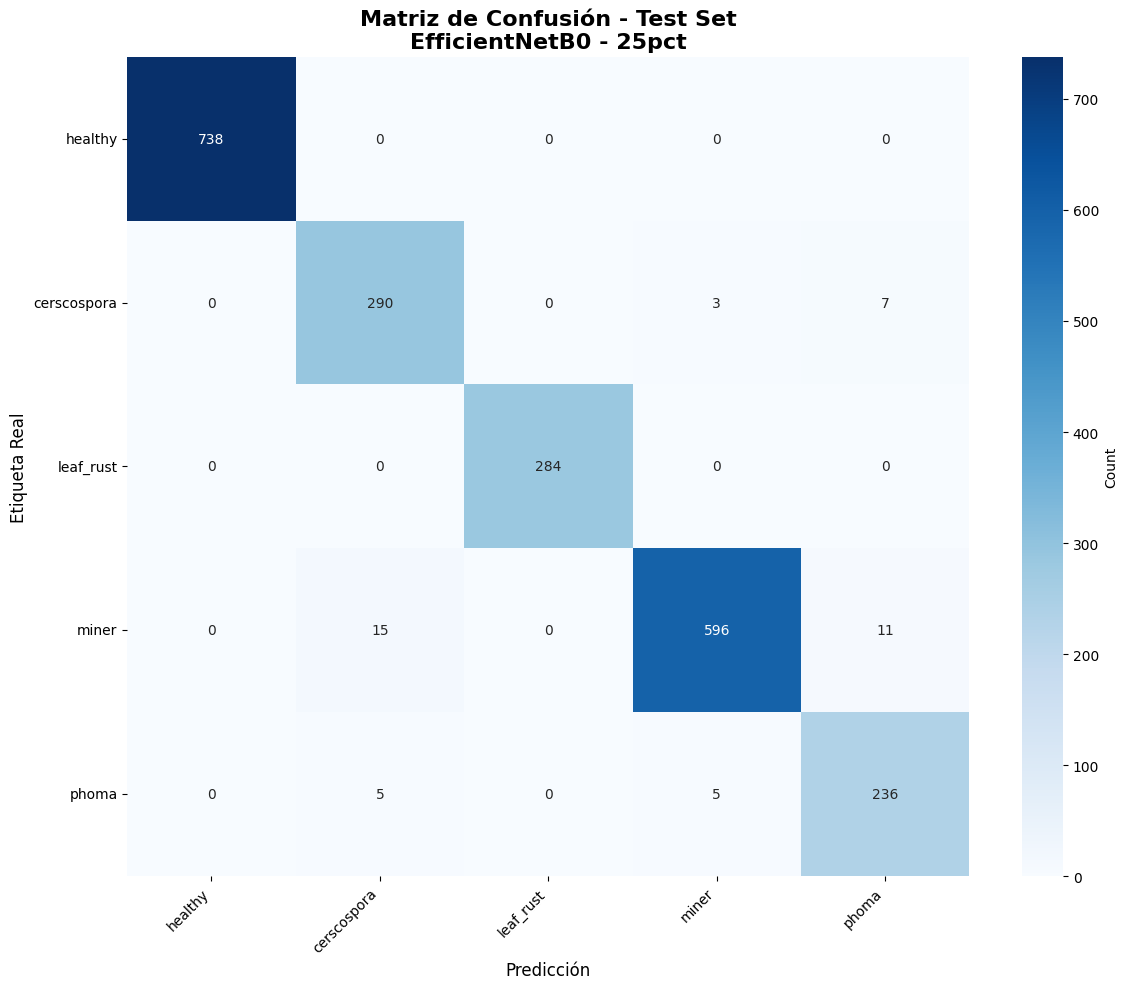

💾 Matriz de confusión guardada: ../data/models/confusion_matrix_EfficientNetB0_25pct.png


In [82]:
print("\n" + "="*60)
print("🧪 EVALUACIÓN FINAL EN TEST SET")
print("="*60)

# Evaluar en test
test_results = model.evaluate(test_dataset, verbose=1)
print(f"\nTest Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")

# Predecir en test
y_pred_test = model.predict(test_dataset, verbose=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Identificar clases presentes en test
unique_test_classes = np.unique(test_labels)
print(f"\nClases presentes en test set: {unique_test_classes}")

# Verificar si todas las clases están presentes
missing_classes = set(range(NUM_CLASSES)) - set(unique_test_classes)
if missing_classes:
    print(f"⚠️  Clases ausentes en test: {[CLASS_NAMES[i] for i in missing_classes]}")

# Classification report
print("\n" + "="*60)
print("📊 CLASSIFICATION REPORT")
print("="*60)

# Opción: Especificar solo las clases presentes (recomendado para muestras pequeñas)
if len(unique_test_classes) < NUM_CLASSES:
    # Usar solo nombres de clases presentes
    target_names_present = [CLASS_NAMES[i] for i in unique_test_classes]
    print(classification_report(test_labels, y_pred_test_classes,
                              labels=unique_test_classes,
                              target_names=target_names_present,
                              digits=4))
    print(f"\n⚠️  Nota: Solo se muestran las {len(unique_test_classes)} clases presentes en el test set.")
else:
    # Todas las clases presentes, usar reporte completo
    print(classification_report(test_labels, y_pred_test_classes,
                              target_names=CLASS_NAMES,
                              digits=4))

# Matriz de confusión
cm = confusion_matrix(test_labels, y_pred_test_classes, labels=unique_test_classes)

# Usar solo nombres de clases presentes para los ejes
axis_labels = [CLASS_NAMES[i] for i in unique_test_classes]

# Nombre descriptivo para la matriz de confusión
confusion_matrix_filename = f'{MODELS_PATH}/confusion_matrix_{model_name}_{sample_name}.png'

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=axis_labels, yticklabels=axis_labels,
            cbar_kws={'label': 'Count'})
plt.title(f'Matriz de Confusión - Test Set\n{model_name} - {sample_name}',
          fontsize=16, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(confusion_matrix_filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Matriz de confusión guardada: {confusion_matrix_filename}")


## Analisis de falsos negativos

In [83]:
print("\n" + "="*60)
print("⚠️  ANÁLISIS DETALLADO DE FALSOS NEGATIVOS")
print("="*60)

healthy_idx = CLASS_NAMES.index('healthy')

print("\n⚠️  Falsos Negativos (Enfermedad → Healthy):")

total_fn = 0
total_disease_samples = 0

for idx, class_name in enumerate(CLASS_NAMES):
    if class_name == 'healthy':
        continue  # Saltar la clase healthy

    # Máscara para casos reales de esta enfermedad
    mask_true = (test_labels == idx)
    total_cases = np.sum(mask_true)

    if total_cases > 0:
        # Máscara para predicciones incorrectas como 'healthy'
        mask_pred_healthy = (y_pred_test_classes == healthy_idx)

        # Falsos negativos: casos reales de enfermedad predichos como healthy
        fn = np.sum(mask_true & mask_pred_healthy)
        fn_rate = (fn / total_cases) * 100

        print(f"  {class_name:20s}: {fn}/{total_cases} ({fn_rate:.1f}%)")

        total_fn += fn
        total_disease_samples += total_cases

print(f"\n🔴 Total Falsos Negativos: {total_fn}")
print(f"📊 Total casos de enfermedad en test: {total_disease_samples}")

if total_disease_samples > 0:
    overall_fn_rate = (total_fn / total_disease_samples) * 100
    print(f"📈 Tasa global de Falsos Negativos: {overall_fn_rate:.1f}%")

# Análisis adicional: ¿A qué clases se confunden las enfermedades?
print(f"\n🔍 Análisis de confusiones por enfermedad:")
for idx, class_name in enumerate(CLASS_NAMES):
    if class_name == 'healthy':
        continue

    mask_true = (test_labels == idx)
    total_cases = np.sum(mask_true)

    if total_cases > 0:
        print(f"\n  {class_name} (total: {total_cases}):")
        predictions_for_this_class = y_pred_test_classes[mask_true]

        for pred_idx, pred_class in enumerate(CLASS_NAMES):
            count = np.sum(predictions_for_this_class == pred_idx)
            if count > 0:
                percentage = (count / total_cases) * 100
                emoji = "✅" if pred_idx == idx else ("❌" if pred_class == 'healthy' else "🔄")
                print(f"    {emoji} → {pred_class:15s}: {count}/{total_cases} ({percentage:.1f}%)")


⚠️  ANÁLISIS DETALLADO DE FALSOS NEGATIVOS

⚠️  Falsos Negativos (Enfermedad → Healthy):
  cerscospora         : 0/300 (0.0%)
  leaf_rust           : 0/284 (0.0%)
  miner               : 0/622 (0.0%)
  phoma               : 0/246 (0.0%)

🔴 Total Falsos Negativos: 0
📊 Total casos de enfermedad en test: 1452
📈 Tasa global de Falsos Negativos: 0.0%

🔍 Análisis de confusiones por enfermedad:

  cerscospora (total: 300):
    ✅ → cerscospora    : 290/300 (96.7%)
    🔄 → miner          : 3/300 (1.0%)
    🔄 → phoma          : 7/300 (2.3%)

  leaf_rust (total: 284):
    ✅ → leaf_rust      : 284/284 (100.0%)

  miner (total: 622):
    🔄 → cerscospora    : 15/622 (2.4%)
    ✅ → miner          : 596/622 (95.8%)
    🔄 → phoma          : 11/622 (1.8%)

  phoma (total: 246):
    🔄 → cerscospora    : 5/246 (2.0%)
    🔄 → miner          : 5/246 (2.0%)
    ✅ → phoma          : 236/246 (95.9%)


## Ajuste de threshold

In [84]:
print("\n" + "="*60)
print("🎚️  AJUSTE DE THRESHOLD PARA REDUCIR FALSOS NEGATIVOS")
print("="*60)

def adjust_predictions_penalize_healthy(y_pred_proba, penalty=0.7):
    """Penaliza la clase healthy para reducir falsos negativos"""
    y_adjusted = y_pred_proba.copy()
    y_adjusted[:, healthy_idx] *= penalty
    return np.argmax(y_adjusted, axis=1)

print("\nProbando diferentes penalizaciones para 'healthy':\n")
best_penalty = 1.0
best_f1 = 0

for penalty in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]:
    y_pred_adjusted = adjust_predictions_penalize_healthy(y_pred_test, penalty)

    from sklearn.metrics import precision_score, f1_score

    recall = recall_score(test_labels, y_pred_adjusted, average='macro')
    precision = precision_score(test_labels, y_pred_adjusted, average='macro')
    f1 = f1_score(test_labels, y_pred_adjusted, average='macro')

    # Contar falsos negativos
    fn_count = 0
    for idx in range(NUM_CLASSES):
        if CLASS_NAMES[idx] != 'healthy':
            mask_true = (test_labels == idx)
            mask_pred_healthy = (y_pred_adjusted == healthy_idx)
            fn_count += np.sum(mask_true & mask_pred_healthy)

    print(f"Penalty = {penalty:.1f}:")
    print(f"  Recall:    {recall:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  FN count:  {fn_count}")
    print()

    if f1 > best_f1:
        best_f1 = f1
        best_penalty = penalty

print(f"✅ Mejor penalty: {best_penalty} (F1={best_f1:.4f})")


🎚️  AJUSTE DE THRESHOLD PARA REDUCIR FALSOS NEGATIVOS

Probando diferentes penalizaciones para 'healthy':

Penalty = 1.0:
  Recall:    0.9768
  Precision: 0.9703
  F1-Score:  0.9734
  FN count:  0

Penalty = 0.9:
  Recall:    0.9768
  Precision: 0.9703
  F1-Score:  0.9734
  FN count:  0

Penalty = 0.8:
  Recall:    0.9768
  Precision: 0.9703
  F1-Score:  0.9734
  FN count:  0

Penalty = 0.7:
  Recall:    0.9768
  Precision: 0.9703
  F1-Score:  0.9734
  FN count:  0

Penalty = 0.6:
  Recall:    0.9768
  Precision: 0.9703
  F1-Score:  0.9734
  FN count:  0

Penalty = 0.5:
  Recall:    0.9768
  Precision: 0.9703
  F1-Score:  0.9734
  FN count:  0

✅ Mejor penalty: 1.0 (F1=0.9734)


## Visualizacion de metricas

📊 Combinando métricas de ambas fases de entrenamiento...
✅ Datos disponibles: 50 epochs
💾 Métricas de entrenamiento guardadas: ../data/models/training_metrics_EfficientNetB0_25pct.png


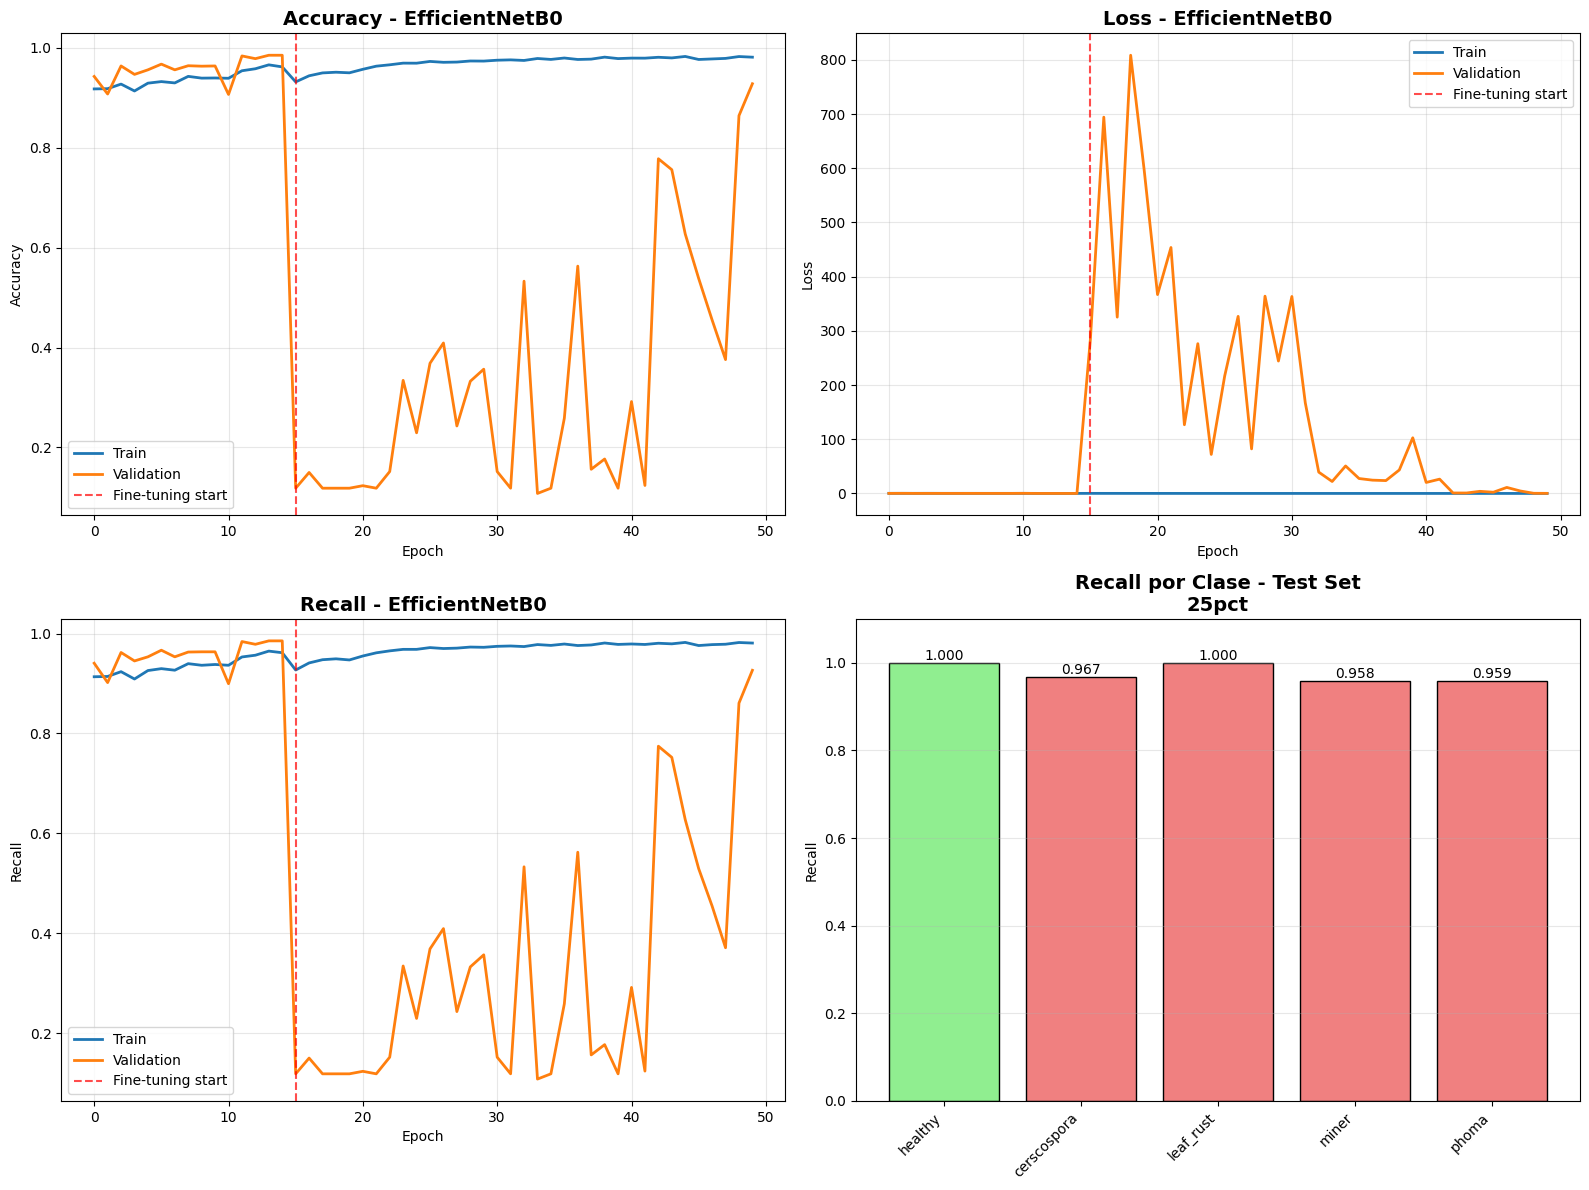

In [85]:
# Función para combinar historiales de forma segura
def safe_combine_histories(hist1, hist2, key):
    """Combina historiales manejando casos donde hist2 puede estar vacío"""
    values1 = hist1.history.get(key, [])
    values2 = hist2.history.get(key, []) if hist2 != hist1 else []
    return values1 + values2

# Verificar si tenemos dos fases diferentes
has_two_phases = (history_phase2 != history_phase1 and
                  len(history_phase2.history.get('accuracy', [])) > 0)

if has_two_phases:
    print("📊 Combinando métricas de ambas fases de entrenamiento...")
    all_accuracy = safe_combine_histories(history_phase1, history_phase2, 'accuracy')
    all_val_accuracy = safe_combine_histories(history_phase1, history_phase2, 'val_accuracy')
    all_loss = safe_combine_histories(history_phase1, history_phase2, 'loss')
    all_val_loss = safe_combine_histories(history_phase1, history_phase2, 'val_loss')
    all_recall = safe_combine_histories(history_phase1, history_phase2, 'recall')
    all_val_recall = safe_combine_histories(history_phase1, history_phase2, 'val_recall')
    fine_tune_epoch = len(history_phase1.history['accuracy'])
else:
    print("📊 Usando métricas de una sola fase de entrenamiento...")
    all_accuracy = history_phase1.history.get('accuracy', [])
    all_val_accuracy = history_phase1.history.get('val_accuracy', [])
    all_loss = history_phase1.history.get('loss', [])
    all_val_loss = history_phase1.history.get('val_loss', [])
    all_recall = history_phase1.history.get('recall', [])
    all_val_recall = history_phase1.history.get('val_recall', [])
    fine_tune_epoch = None

# Verificar que tenemos datos
if not all_accuracy:
    print("❌ Error: No hay datos de entrenamiento para graficar")
else:
    print(f"✅ Datos disponibles: {len(all_accuracy)} epochs")

# Nombre descriptivo para las métricas
metrics_filename = f'{MODELS_PATH}/training_metrics_{model_name}_{sample_name}.png'

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy - CORREGIDO
if all_accuracy and all_val_accuracy:
    epochs_range = range(len(all_accuracy))
    axes[0, 0].plot(epochs_range, all_accuracy, label='Train', linewidth=2)
    axes[0, 0].plot(epochs_range, all_val_accuracy, label='Validation', linewidth=2)

    # Línea de fine-tuning solo si hay dos fases
    if has_two_phases and fine_tune_epoch is not None and fine_tune_epoch < len(all_accuracy):
        axes[0, 0].axvline(x=fine_tune_epoch, color='red', linestyle='--',
                          label='Fine-tuning start', alpha=0.7)

    axes[0, 0].set_title(f'Accuracy - {model_name}', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
else:
    axes[0, 0].text(0.5, 0.5, 'No data available', ha='center', va='center',
                   transform=axes[0, 0].transAxes, fontsize=14)
    axes[0, 0].set_title('Accuracy - No Data')

# Loss - CORREGIDO
if all_loss and all_val_loss:
    epochs_range = range(len(all_loss))
    axes[0, 1].plot(epochs_range, all_loss, label='Train', linewidth=2)
    axes[0, 1].plot(epochs_range, all_val_loss, label='Validation', linewidth=2)

    if has_two_phases and fine_tune_epoch is not None and fine_tune_epoch < len(all_loss):
        axes[0, 1].axvline(x=fine_tune_epoch, color='red', linestyle='--',
                          label='Fine-tuning start', alpha=0.7)

    axes[0, 1].set_title(f'Loss - {model_name}', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'No data available', ha='center', va='center',
                   transform=axes[0, 1].transAxes, fontsize=14)
    axes[0, 1].set_title('Loss - No Data')

# Recall - CORREGIDO
if all_recall and all_val_recall:
    epochs_range = range(len(all_recall))
    axes[1, 0].plot(epochs_range, all_recall, label='Train', linewidth=2)
    axes[1, 0].plot(epochs_range, all_val_recall, label='Validation', linewidth=2)

    if has_two_phases and fine_tune_epoch is not None and fine_tune_epoch < len(all_recall):
        axes[1, 0].axvline(x=fine_tune_epoch, color='red', linestyle='--',
                          label='Fine-tuning start', alpha=0.7)

    axes[1, 0].set_title(f'Recall - {model_name}', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No data available', ha='center', va='center',
                   transform=axes[1, 0].transAxes, fontsize=14)
    axes[1, 0].set_title('Recall - No Data')

# Recall por clase - CORREGIDO
if 'y_pred_test_classes' in locals() and 'test_labels' in locals():
    recall_per_class = []
    class_names_present = []

    for idx in range(NUM_CLASSES):
        mask = test_labels == idx
        if np.sum(mask) > 0:  # Solo incluir clases que existen en test
            class_recall = np.sum(y_pred_test_classes[mask] == idx) / np.sum(mask)
            recall_per_class.append(class_recall)
            class_names_present.append(CLASS_NAMES[idx])

    if recall_per_class:
        colors = ['lightgreen' if cn == 'healthy' else 'lightcoral' for cn in class_names_present]
        bars = axes[1, 1].bar(range(len(recall_per_class)), recall_per_class,
                             color=colors, edgecolor='black')
        axes[1, 1].set_xticks(range(len(class_names_present)))
        axes[1, 1].set_xticklabels(class_names_present, rotation=45, ha='right')
        axes[1, 1].set_title(f'Recall por Clase - Test Set\n{sample_name}',
                            fontsize=14, fontweight='bold')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].set_ylim([0, 1.1])
        axes[1, 1].grid(True, axis='y', alpha=0.3)

        # Agregar valores en las barras
        for bar, val in zip(bars, recall_per_class):
            height = bar.get_height()
            axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                           f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    else:
        axes[1, 1].text(0.5, 0.5, 'No test data available', ha='center', va='center',
                       transform=axes[1, 1].transAxes, fontsize=14)
        axes[1, 1].set_title('Recall por Clase - No Data')
else:
    axes[1, 1].text(0.5, 0.5, 'Test evaluation not completed', ha='center', va='center',
                   transform=axes[1, 1].transAxes, fontsize=14)
    axes[1, 1].set_title('Recall por Clase - Pending')

plt.tight_layout()

try:
    plt.savefig(metrics_filename, dpi=300, bbox_inches='tight')
    print(f"💾 Métricas de entrenamiento guardadas: {metrics_filename}")
except Exception as e:
    print(f"⚠️ Error al guardar gráfico: {e}")

plt.show()

## Guardar modelo

In [86]:
# Nombres descriptivos para los archivos finales
final_weights_filename = f'{MODELS_PATH}/final_weights_{model_name}_{sample_name}.h5'
final_model_filename = f'{MODELS_PATH}/final_model_{model_name}_{sample_name}.keras'

# Guardar arquitectura y pesos por separado para evitar problemas de serialización
model.save_weights(final_weights_filename)
print(f"\n💾 Pesos del modelo guardados: '{final_weights_filename}'")

# Intentar guardar modelo completo (puede fallar con modelos complejos)
try:
    model.save(final_model_filename)
    print(f"💾 Modelo completo guardado: '{final_model_filename}'")
except Exception as e:
    print(f"⚠️  No se pudo guardar el modelo completo: {e}")
    print("ℹ️  Usa solo los pesos (.h5) para cargar el modelo más tarde")

print("\n" + "="*60)
print("✅ ENTRENAMIENTO COMPLETADO")
print("="*60)
print("\n📁 Archivos guardados en:", MODELS_PATH)
print(f"  • {os.path.basename(final_weights_filename)} (pesos)")
print(f"  • {os.path.basename(checkpoint_filename)} (mejor modelo - solo pesos)")
print(f"  • {os.path.basename(confusion_matrix_filename)} (matriz de confusión)")
print(f"  • {os.path.basename(metrics_filename)} (gráficos de entrenamiento)")
print("\n💡 Tip: Usa el mejor penalty encontrado al hacer predicciones en producción")
print(f"\n📖 Para cargar el modelo:")
print(f"   model = build_{model_name.lower().replace('b0', '_model')}()")
print(f"   model.load_weights('{final_weights_filename}')")


💾 Pesos del modelo guardados: '../data/models/final_weights_EfficientNetB0_25pct.h5'
⚠️  No se pudo guardar el modelo completo: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
ℹ️  Usa solo los pesos (.h5) para cargar el modelo más tarde

✅ ENTRENAMIENTO COMPLETADO

📁 Archivos guardados en: ../data/models
  • final_weights_EfficientNetB0_25pct.h5 (pesos)
  • best_model_EfficientNetB0_25pct.keras (mejor modelo - solo pesos)
  • confusion_matrix_EfficientNetB0_25pct.png (matriz de confusión)
  • training_metrics_EfficientNetB0_25pct.png (gráficos de entrenamiento)

💡 Tip: Usa el mejor penalty encontrado al hacer predicciones en producción

📖 Para cargar el modelo:
   model = build_efficientnet_model()
   model.load_weights('../data/models/final_weights_EfficientNetB0_25pct.h5')


# Para hacer predicciones:

Al hacer predicciones nuevas:


In [ ]:
#y_pred_proba = model.predict(new_images)
#y_pred_final = adjust_predictions_penalize_healthy(y_pred_proba, penalty=0.7)

¿Cuándo Usar Qué Penalty?

In [ ]:
# Aplicación de Investigación (laboratorio):
penalty = 0.9  # Conservador, pocas falsas alarmas

# Aplicación Comercial (campo):
penalty = 0.7  # Balance, F1 óptimo (RECOMENDADO)

# Aplicación Crítica (prevenir epidemia):
penalty = 0.5  # Agresivo, detecta todo aunque haya falsas alarmas

In [87]:
# Debugging de historiales
print("🔍 DEBUG - Verificando historiales:")
print(f"history_phase1 keys: {list(history_phase1.history.keys())}")
print(f"history_phase1 accuracy length: {len(history_phase1.history.get('accuracy', []))}")

if history_phase2 != history_phase1:
    print(f"history_phase2 keys: {list(history_phase2.history.keys())}")
    print(f"history_phase2 accuracy length: {len(history_phase2.history.get('accuracy', []))}")
else:
    print("history_phase2 es igual a history_phase1 (no hubo fine-tuning)")

if 'test_labels' in locals():
    print(f"test_labels shape: {np.array(test_labels).shape}")
    print(f"Clases únicas en test: {np.unique(test_labels)}")
else:
    print("test_labels no definido aún")

🔍 DEBUG - Verificando historiales:
history_phase1 keys: ['loss', 'accuracy', 'recall', 'precision', 'disease_recall', 'auc', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision', 'val_disease_recall', 'val_auc', 'lr']
history_phase1 accuracy length: 15
history_phase2 keys: ['loss', 'accuracy', 'recall', 'precision', 'disease_recall', 'auc', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision', 'val_disease_recall', 'val_auc', 'lr']
history_phase2 accuracy length: 35
test_labels shape: (2190,)
Clases únicas en test: [0 1 2 3 4]


In [98]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
from PIL import Image

# Reconstruir arquitectura (copia del código original)
def build_efficientnet_model():
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Base model directamente
    x = base_model(inputs, training=False)

    # Classification head
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(1024, activation='relu', name="dense_1")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(512, activation='relu', name="dense_2")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(256, activation='relu', name="dense_3")(x)
    x = layers.Dropout(0.1)(x)

    outputs = layers.Dense(NUM_CLASSES, activation='softmax', name="predictions")(x)

    model = keras.Model(inputs, outputs)
    return model, base_model

model_to_use = 'final_weights_EfficientNetB0_25pct.h5'

# Cargar modelo
model, _ = build_efficientnet_model()
model.load_weights(f'../data/models/{model_to_use}')

# Clases
CLASS_NAMES = ['healthy', 'cerscospora', 'leaf_rust', 'miner', 'phoma']

# Predecir
img = Image.open('../data/imgs_for_testing/rust.jpg').resize((224, 224))
img = img.convert('RGB')
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, 0)

predictions = model.predict(img_array)
# predictions = adjust_predictions_penalize_healthy(predictions, penalty=0.9)
predicted_class = CLASS_NAMES[np.argmax(predictions[0])]

print(f"Predicción: {predicted_class}")
print(f"Probabilidades: {predictions[0]}")

1/1 [==============================] - 2s 2s/step
Predicción: phoma
Probabilidades: [1.1092856e-33 2.9939117e-22 1.1544759e-37 1.9859704e-15 1.0000000e+00]
